# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the right PATH

In [8]:
%pwd

'/content'

In [9]:
%cd "/content/drive/MyDrive/Programming/BilderkennungAI"

/content/drive/MyDrive/Programming/BilderkennungAI


# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



In [ ]:
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)

Image in eine tf data pipeline laden (Beispiel)

In [ ]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [ ]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image75.jpg'

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[0.15488835, 0.18233933, 0.20586874],
        [0.57485706, 0.60230803, 0.62583745],
        [0.6990266 , 0.7186344 , 0.74216384],
        ...,
        [0.95758486, 0.97327113, 0.9772608 ],
        [0.9709763 , 0.99058414, 0.99938726],
        [0.94377047, 0.9633783 , 0.9790646 ]],

       [[0.09971406, 0.12716503, 0.15069444],
        [0.5543505 , 0.5818015 , 0.6053309 ],
        [0.8295548 , 0.84916264, 0.87269205],
        ...,
        [0.895343  , 0.9243668 , 0.9431779 ],
        [0.8381128 , 0.8577206 , 0.8734069 ],
        [0.4829892 , 0.50259703, 0.52318525]],

       [[0.17819989, 0.20565087, 0.22918028],
        [0.59256536, 0.62001634, 0.64354575],
        [0.8746732 , 0.894281  , 0.91778994],
        ...,
        [0.10600539, 0.12169167, 0.15698579],
        [0.2830677 , 0.29875398, 0.3340481 ],
        [0.4754016 , 0.49108788, 0.526382  ]],

       ...,

       [[0.78777933, 0.79562247, 0.8426813 ],
        [0.7771858 , 0.78502893, 0.83208776],
        [0.7810461 , 0

In [ ]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [ ]:
images_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = images_generator.next()

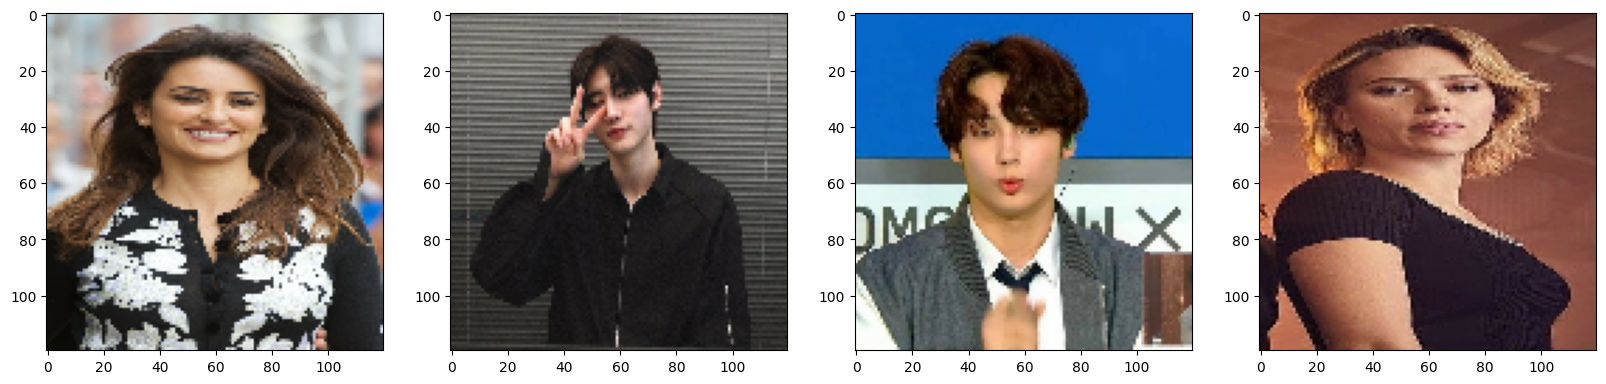

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#

Laden eines Beispielbilds

In [ ]:
image_path = "image13"

In [ ]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [ ]:
size= img.shape
print(size)

(650, 650, 3)


In [ ]:
with open(os.path.join('data','train','labels',image_path+'.json'),'r') as f:
  label = json.load(f)

In [ ]:
label['shapes'][0]['points']

[[174.48275862068965, 39.0], [535.8620689655172, 398.3103448275862]]

Koordinaten Extrahieren und Maßstab ändern

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [ ]:
coords

[174.48275862068965, 39.0, 535.8620689655172, 398.3103448275862]

In [ ]:
coords = list(np.divide(coords,[650,650,650,650]))

In [ ]:
coords

[0.26843501326259944, 0.06, 0.8244031830238726, 0.6127851458885942]

Augmentation implimentieren

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0]


(0.0, 0.419310344827586, 0.7211494252873563, 1.0)

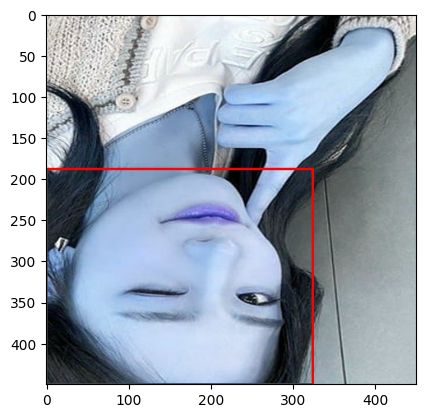

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [ ]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6238726790450928, 0.5544297082228117, 0.19628647214854114, 0.08015915119363395, 'face'].
x_max is less than or equal to x_min for bbox [0.5920424403183026, 0.5544297082228117, 0.10079575596816977, 0.05893899204244032, 'face'].
x_max is less than or equal to x_min for bbox [0.6153846153846154, 0.3931564986737401, 0.38196286472148544, 0.13320954907161806, 'face'].
x_max is less than or equal to x_min for bbox [0.6206896551724138, 0.08228116710875331, 0.35862068965517246, 0.42180371352785145, 'face'].
x_max is less than or equal to x_min for bbox [0.6992042440318302, 0.48864721485411144, 0.26631299734748015, 0.07379310344827586, 'face'].
x_max is less than or equal to x_min for bbox [0.5941644562334218, 0.2520424403183024, 0.3618037135278515, 0.045145888594164456, 'face'].
x_max is less than or equal to x_min for bbox [0.6058355437665783, 0.16928381962864722, 0.3925729442970823, 0.031352785145888594, 'face'].
y_max is less than or equal to 

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.79607844, 0.8223652 , 0.8136029 ],
        [0.8408701 , 0.8643995 , 0.85655636],
        [0.875     , 0.89362746, 0.8882353 ],
        ...,
        [0.2917892 , 0.28394607, 0.2329657 ],
        [0.29436275, 0.27867648, 0.2329044 ],
        [0.36893383, 0.35631126, 0.30919117]],

       [[0.78039217, 0.811826  , 0.80919117],
        [0.82757354, 0.8523897 , 0.85110295],
        [0.8613971 , 0.8849265 , 0.87708336],
        ...,
        [0.25349265, 0.23780638, 0.19123775],
        [0.17536765, 0.14791666, 0.10870098],
        [0.13756128, 0.11452206, 0.07383578]],

       [[0.7710784 , 0.8063725 , 0.80245095],
        [0.8088848 , 0.8441789 , 0.8324142 ],
        [0.8594363 , 0.8947304 , 0.8829657 ],
        ...,
        [0.1896446 , 0.17395833, 0.13082108],
        [0.20306373, 0.17561275, 0.13639706],
        [0.21421568, 0.1985294 , 0.15539216]],

       ...,

       [[0.4764706 , 0.5245098 , 0.49068627],
        [0.47457108, 0.5216299 , 0.48241422],
        [0.4867647 , 0

Labels vorbereiten

In [ ]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2854, 0.4937, 0.7144, 1.    ], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(1260, 1260, 540, 540, 180, 180)

7.2 Create Final Dataset (Image/Label)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[0]

array([[[[8.62500012e-01, 7.46813715e-01, 8.05637240e-01],
         [9.21384811e-01, 8.20894599e-01, 8.83639693e-01],
         [8.65379930e-01, 7.76164234e-01, 8.50980401e-01],
         ...,
         [1.89215690e-01, 2.67647058e-01, 4.12745088e-01],
         [1.76470593e-01, 2.54901975e-01, 4.00000006e-01],
         [1.71017155e-01, 2.49448523e-01, 3.94546568e-01]],

        [[8.41850519e-01, 6.75183833e-01, 7.14399517e-01],
         [8.89644623e-01, 7.32230365e-01, 7.74877429e-01],
         [8.90992641e-01, 7.57720590e-01, 8.01286757e-01],
         ...,
         [1.95588231e-01, 2.74019599e-01, 4.19117659e-01],
         [1.77389711e-01, 2.55821079e-01, 4.00919110e-01],
         [1.74019605e-01, 2.52450973e-01, 3.97549033e-01]],

        [[7.94730365e-01, 5.98651946e-01, 6.33946061e-01],
         [7.91237772e-01, 6.06923997e-01, 6.38296545e-01],
         [8.02818656e-01, 6.34191155e-01, 6.68198526e-01],
         ...,
         [1.96017161e-01, 2.74448544e-01, 4.19546574e-01],
         [

7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


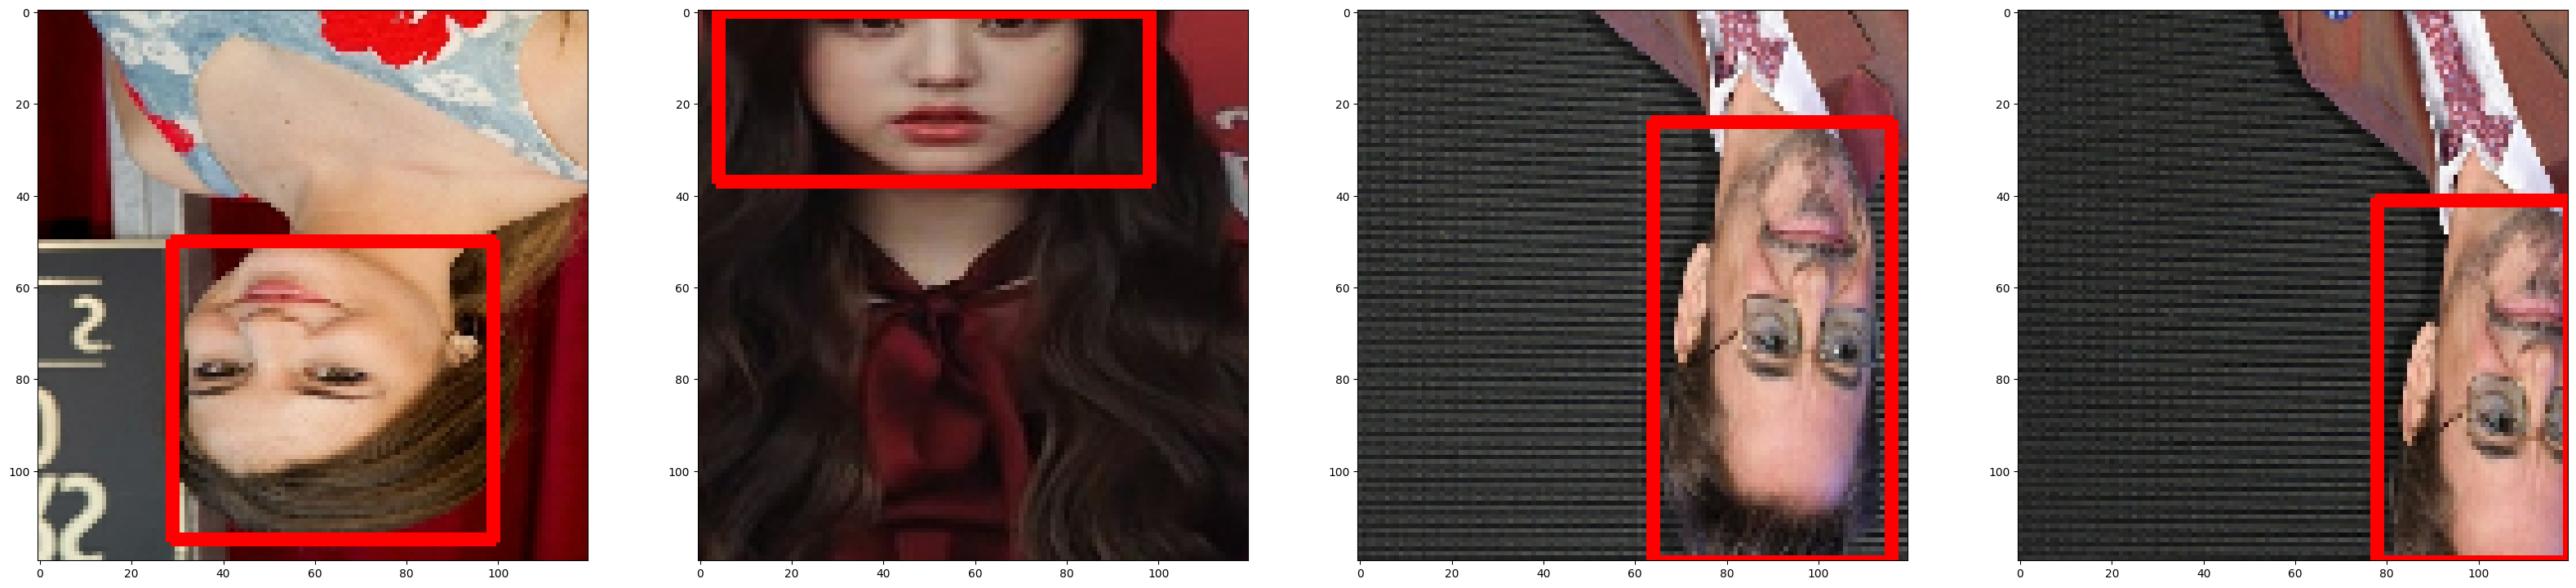

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 9s 9s/step


In [ ]:
classes, coords

(array([[0.2025502 ],
        [0.30176777],
        [0.32200113],
        [0.30061662],
        [0.38164675],
        [0.23109902],
        [0.27962333],
        [0.33094394]], dtype=float32),
 array([[0.5511412 , 0.4175846 , 0.46064264, 0.74954623],
        [0.43536022, 0.41304407, 0.51275074, 0.7362771 ],
        [0.54666674, 0.46146023, 0.52248573, 0.64929587],
        [0.52907026, 0.42143178, 0.4896069 , 0.7214217 ],
        [0.5793175 , 0.37100363, 0.39657086, 0.6541931 ],
        [0.5927074 , 0.30038   , 0.51639855, 0.7142958 ],
        [0.49740276, 0.36618483, 0.43227822, 0.6046158 ],
        [0.5196466 , 0.4037402 , 0.45130363, 0.6255908 ]], dtype=float32))

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8247766>

In [ ]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2422836>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8247766>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
158/158 [==============================] - 28s 158ms/step - total_loss: 0.0024 - class_loss: 1.7091e-05 - regress_loss: 0.0024 - val_total_loss: 0.1126 - val_class_loss: 4.7971e-05 - val_regress_loss: 0.1126
Epoch 2/15
158/158 [==============================] - 28s 158ms/step - total_loss: 0.0027 - class_loss: 1.5319e-05 - regress_loss: 0.0027 - val_total_loss: 0.1467 - val_class_loss: 4.0323e-05 - val_regress_loss: 0.1467
Epoch 3/15
158/158 [==============================] - 28s 160ms/step - total_loss: 0.0029 - class_loss: 1.4796e-05 - regress_loss: 0.0029 - val_total_loss: 0.0491 - val_class_loss: 2.6495e-05 - val_regress_loss: 0.0491
Epoch 4/15
158/158 [==============================] - 28s 159ms/step - total_loss: 0.0025 - class_loss: 1.6997e-05 - regress_loss: 0.0025 - val_total_loss: 0.0828 - val_class_loss: 4.2828e-05 - val_regress_loss: 0.0828
Epoch 5/15
158/158 [==============================] - 28s 159ms/step - total_loss: 0.0024 - class_loss: 1.4619e-05 - regress

## 10.3 Plot Performance

In [ ]:
hist.history

{'total_loss': [0.0011302221100777388,
  0.0007448224350810051,
  0.0016161809908226132,
  0.0011770145501941442,
  0.000670459761749953,
  0.00036843609996140003,
  0.0011264055501669645,
  0.0005583561724051833,
  0.00028318894328549504,
  0.0007323867175728083,
  0.000830191420391202,
  0.0018404327565804124,
  0.0014123087748885155,
  0.00033955610706470907,
  0.0010849748505279422],
 'class_loss': [9.50703633861849e-06,
  -0.0,
  5.960467888144194e-07,
  2.3976950615178794e-05,
  8.136157703120261e-06,
  2.1010698674217565e-06,
  3.0398473427339923e-06,
  2.712017703743186e-06,
  2.682209867543861e-07,
  1.1920931797249068e-07,
  5.960465188081798e-08,
  3.278257736383239e-07,
  5.483675067807781e-06,
  1.7881400538044545e-07,
  -0.0],
 'regress_loss': [0.0011254686396569014,
  0.0007448224350810051,
  0.0016158829675987363,
  0.0011650261003524065,
  0.0006663916865363717,
  0.00036738556809723377,
  0.001124885631725192,
  0.0005570001667365432,
  0.0002830548328347504,
  0.0007

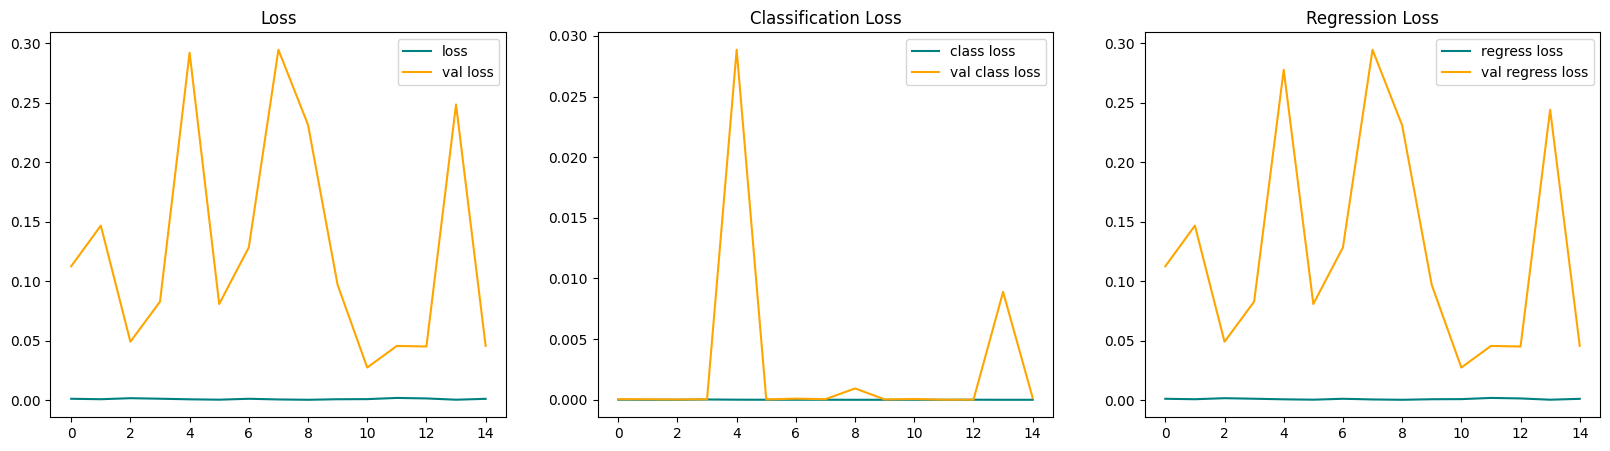

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()
test_sample

(array([[[[6.35294139e-01, 4.66666669e-01, 2.98039228e-01],
          [6.03431344e-01, 4.34803933e-01, 2.66176462e-01],
          [6.01776958e-01, 4.33149517e-01, 2.68443614e-01],
          ...,
          [5.68811297e-01, 5.13909340e-01, 4.08026963e-01],
          [5.65992653e-01, 5.22855401e-01, 4.13051456e-01],
          [5.73529422e-01, 5.33333361e-01, 4.22058821e-01]],
 
         [[6.37745082e-01, 4.69117641e-01, 3.00490201e-01],
          [6.03431344e-01, 4.34803933e-01, 2.66176462e-01],
          [6.00000024e-01, 4.31372553e-01, 2.66666681e-01],
          ...,
          [5.76041639e-01, 5.21139681e-01, 4.15257365e-01],
          [5.72487772e-01, 5.29350519e-01, 4.19546574e-01],
          [5.75183809e-01, 5.34987748e-01, 4.23713237e-01]],
 
         [[6.37438715e-01, 4.68811274e-01, 3.00183833e-01],
          [6.07352912e-01, 4.38725501e-01, 2.70098031e-01],
          [6.03921592e-01, 4.35294122e-01, 2.70588249e-01],
          ...,
          [5.76409340e-01, 5.21507382e-01, 4.1562

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 39ms/step


In [ ]:
yhat

[array([[1.        ],
        [0.9999924 ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.9999988 ],
        [0.99999464],
        [0.9999995 ]], dtype=float32),
 array([[0.32012022, 0.00264503, 0.9873374 , 0.80467784],
        [0.19065237, 0.23224686, 0.88385206, 0.92893314],
        [0.01908908, 0.31993625, 0.8719646 , 0.9975956 ],
        [0.05395763, 0.29975528, 0.5927712 , 0.9875107 ],
        [0.14331345, 0.3176422 , 0.67815614, 0.9891487 ],
        [0.07520346, 0.00122973, 0.75814366, 0.2627151 ],
        [0.08717193, 0.00627077, 0.8473096 , 0.3724155 ],
        [0.01025801, 0.00257892, 0.6331281 , 0.46309865]], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


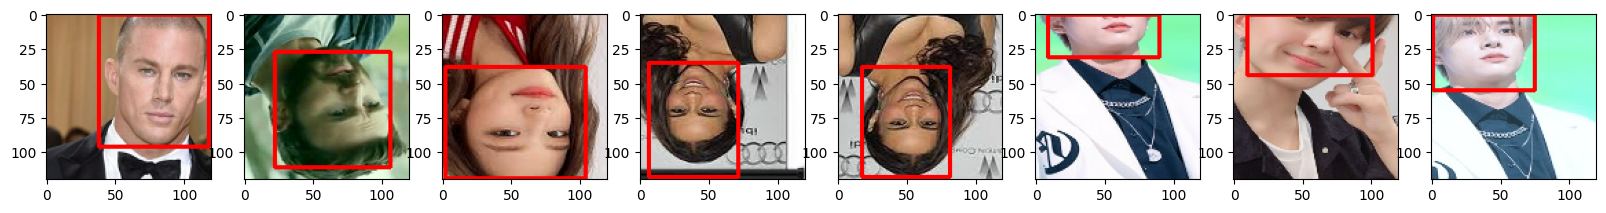

In [ ]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save and Load the Model

In [10]:
#Model Speicherung
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [11]:
facetracker = load_model('facetracker.h5')

## 11.3 Face Detection

In [18]:
rtp_test = cv2.imread(os.path.join("producttest/szene.jpg"))



In [19]:
resized = tf.image.resize(rtp_test, (120,120))
size = rtp_test.shape
yhat = facetracker.predict(np.expand_dims(resized/255,0))
status = yhat[0]
sample_coords = yhat[1][0]



1/1 [==============================] - 0s 66ms/step


In [20]:
status

array([[0.6242089]], dtype=float32)

In [21]:
sample_coords

array([0.21123314, 0.5099292 , 0.5556078 , 0.62572426], dtype=float32)

Es gibt ein Gesicht


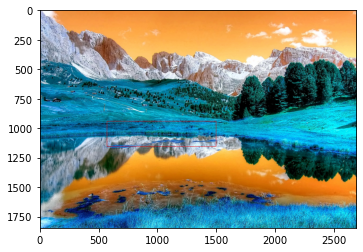

In [23]:
if (status[0][0] > 0.5):
  print("Es gibt ein Gesicht")
  cv2.rectangle(rtp_test,
              tuple(np.multiply(sample_coords[:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
else:
  print("Es gibt kein Gesicht")

plt.imshow(rtp_test)



# Real Detection with Webcam

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()